In [161]:
import ast
import networkx as nx
import importlib
import utils
import style
import graph
import copy
importlib.reload(utils)
importlib.reload(style)
importlib.reload(graph)
from utils import ast_to_networkx, node_transform
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from graph import OurGraph
import xml.dom.minidom
from IPython.display import Image


In [162]:
images_folder = 'images/'
filename_test_py = 'code_samples/test.py'


# How to load python code into ast

In [28]:

with open(filename_test_py, 'r') as file:
    code = file.read()

tree = ast.parse(code)
# astor.to_source(tree)

# Print the AST
print(ast.dump(tree))

Module(body=[FunctionDef(name='main', args=arguments(posonlyargs=[], args=[], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[FunctionDef(name='plus', args=arguments(posonlyargs=[], args=[arg(arg='a'), arg(arg='b')], kwonlyargs=[], kw_defaults=[], defaults=[]), body=[Return(value=BinOp(left=Name(id='a', ctx=Load()), op=Add(), right=Name(id='b', ctx=Load())))], decorator_list=[], type_params=[]), Assign(targets=[Tuple(elts=[Name(id='x', ctx=Store()), Name(id='y', ctx=Store())], ctx=Store())], value=Tuple(elts=[Constant(value=1), Constant(value=2)], ctx=Load())), Assign(targets=[Name(id='res', ctx=Store())], value=Call(func=Name(id='plus', ctx=Load()), args=[Name(id='x', ctx=Load()), Name(id='y', ctx=Load())], keywords=[])), Return(value=Name(id='res', ctx=Load()))], decorator_list=[], type_params=[])], type_ignores=[])


visualizing AST using `networkx` library 

/var/folders/cv/g1l8lkc13bj5vxmvqpc3ls5m0000gn/T/ipykernel_36795/4198787734.py:9: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog="dot")


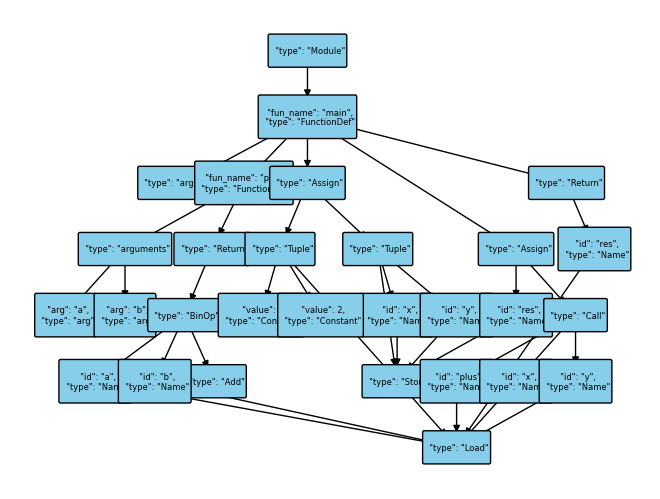

In [30]:
def visualize_ast(filename):
    with open(filename, 'r') as file:
        code = file.read()

    tree = ast.parse(code)
    G = ast_to_networkx(tree)

    node_labels = ({node: node_transform(G, node) for node in G.nodes()})
    pos = graphviz_layout(G, prog="dot")
    pos = {k: (x, 10*y) for k, (x, y) in pos.items()}
    node_size = [(len(node_transform(G, n))+20)*6 for n in G.nodes()]
    nx.draw(G, pos=pos, with_labels=True, node_size=node_size, labels=node_labels, node_shape="s", arrows = True, node_color="none", bbox=dict(facecolor="skyblue", edgecolor='black', boxstyle='round,pad=0.2'), font_size=6)

    plt.show()
G = ast_to_networkx(tree)
visualize_ast('code_samples/test.py')

# Better visualization for AST

2024-04-17 14:13:10.674 draw.io[45229:2194169] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


images/temp.drawio -> images/temp.png


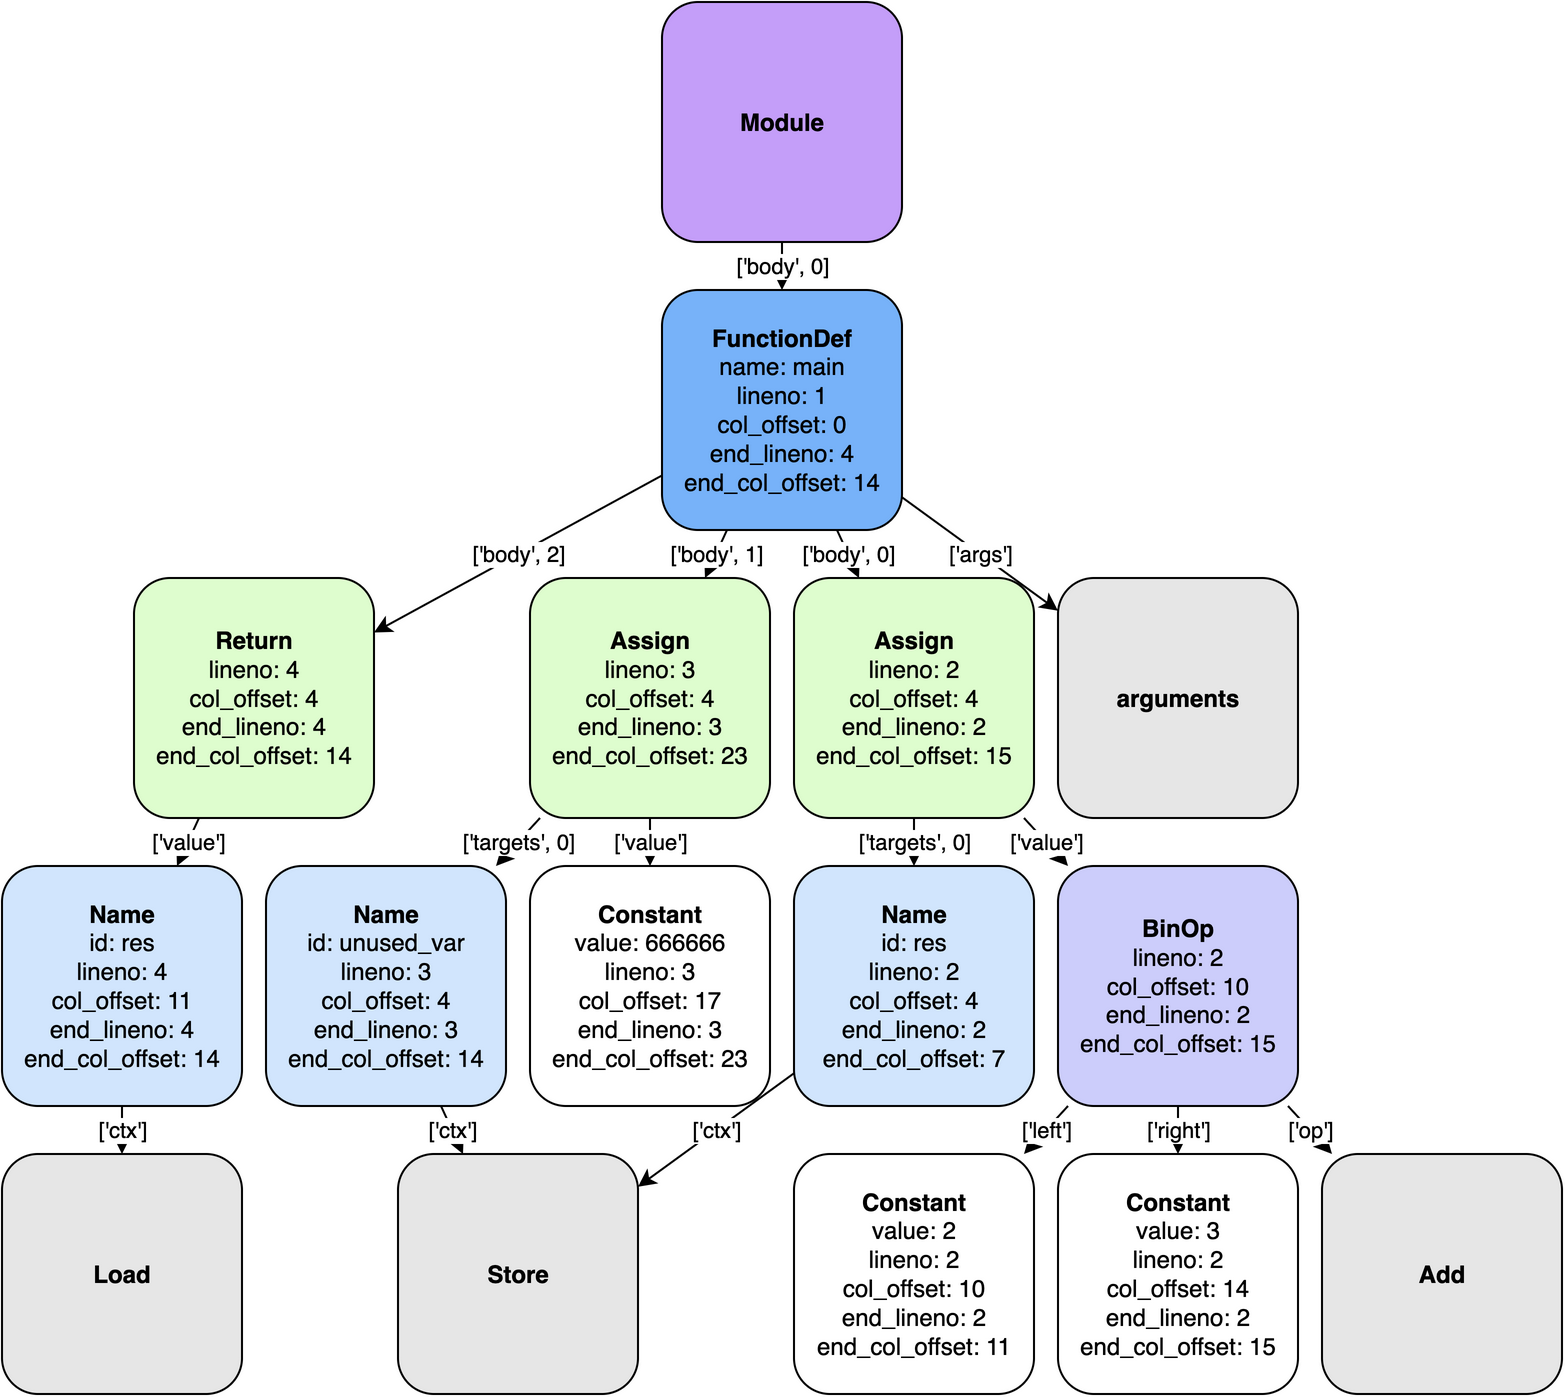

In [50]:
# import graph as g
importlib.reload(style)
importlib.reload(graph)
from graph import OurGraph

from style import OurGraphToXML
import os 
import copy
import expand_function as ef
import ast

def vis_drawio(g: OurGraph, output_file_name: str = 'images/temp2'):
    """
    to use this function you need to install drawio and cleate an alias for its command line interface.
    for mac:
        drawio="/Applications/draw.io.app/Contents/MacOS/draw.io"
    """
    mxfile = OurGraphToXML(y_scaling=2, x_scaling=1).graph_to_xml(g)
    xml_str = xml.dom.minidom.parseString(ET.tostring(mxfile)).toprettyxml()
    
    output_file = f'{output_file_name}.png'
    filename    = f'{output_file_name}.drawio'

    with open(filename, 'w') as file:
        file.write(xml_str) 

    bashCommand = f"/Applications/draw.io.app/Contents/MacOS/draw.io -x -f png --scale 2   -o {output_file} {filename}"
    os.system(bashCommand) 

    return Image(output_file)     

G = OurGraph.from_file(filename_code)
vis_drawio(OurGraph(ef.rename_all_vars(G.ast_tree)))

# Expanding a function call

sh: drawio: command not found


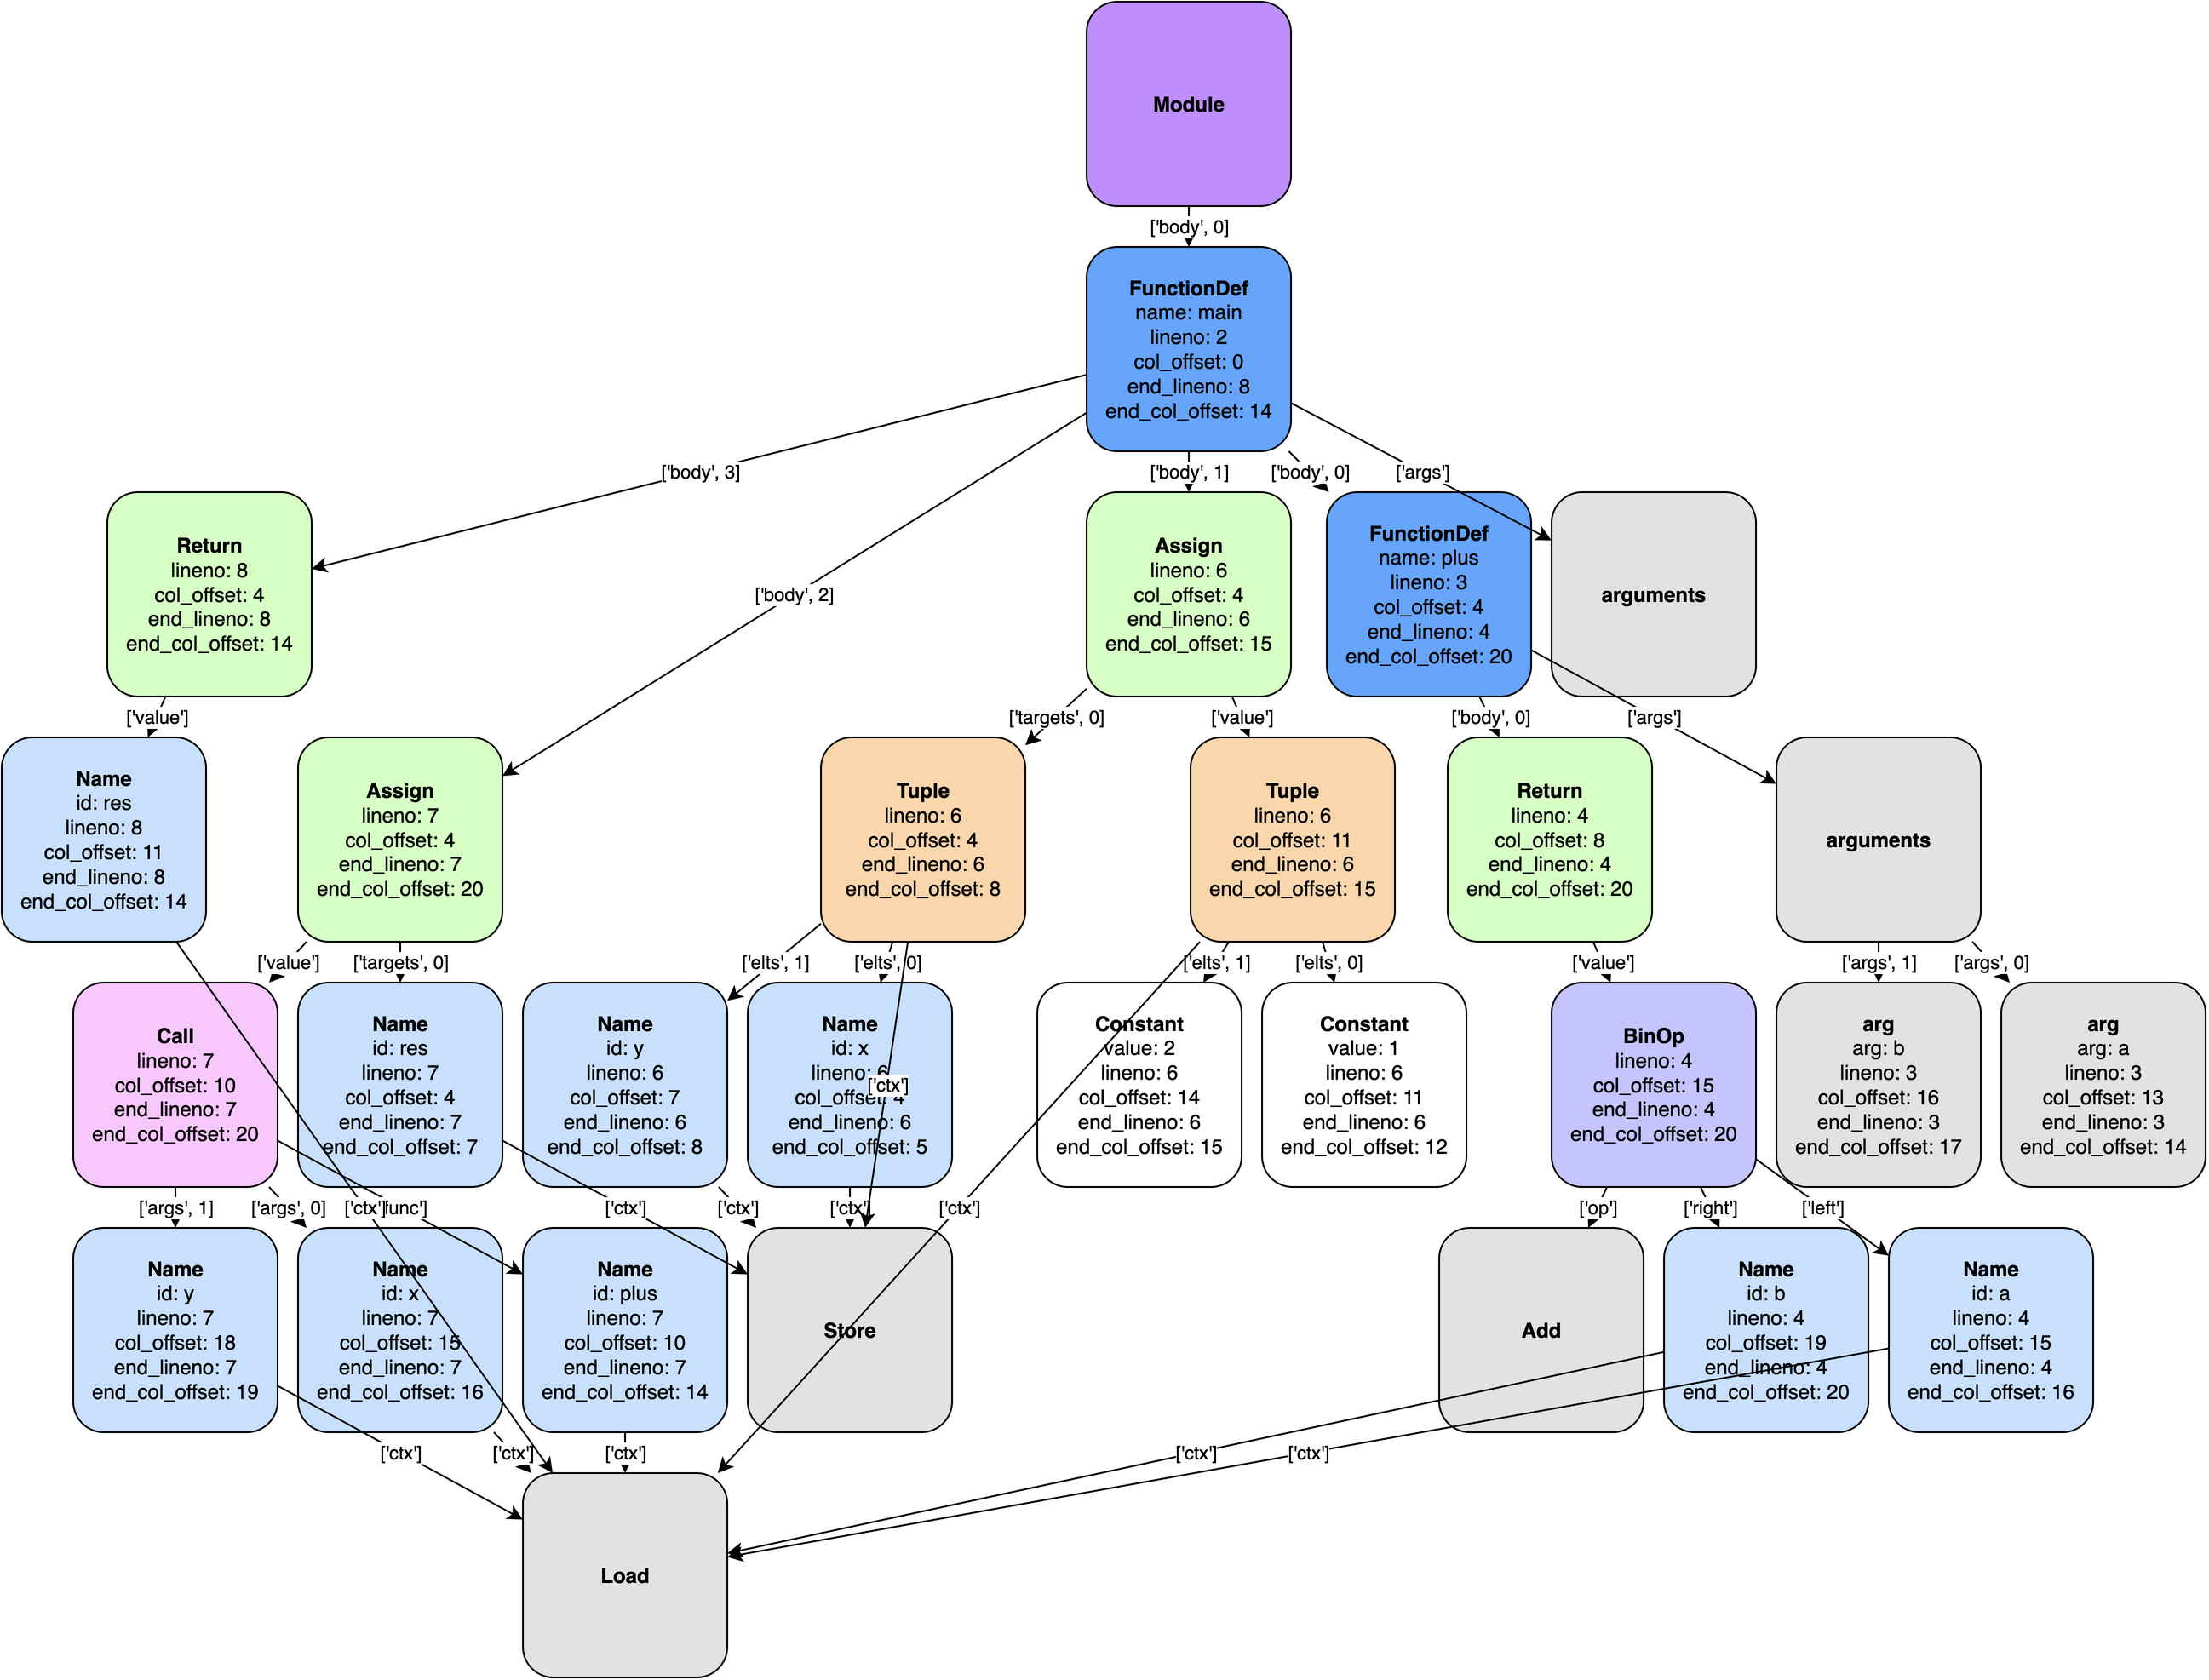

In [4]:
import transforms
importlib.reload(transforms)
from transforms import expand_function

G_new = copy.deepcopy(G)
G_new.refresh()
for node_id, node in G_new.ast_nodes.items():
    if isinstance(node, ast.Call):
        break

expanded = expand_function(G, node_id)
vis_drawio(expanded, 'images/temp')


# Redundant Vars

In [ ]:
import ast
import networkx as nx
from graph import OurGraph

class RedundantVariableRemover(ast.NodeTransformer):
    def __init__(self, redundant_vars):
        self.redundant_vars = redundant_vars

    def visit_Assign(self, node):
        if len(node.targets) == 1 and isinstance(node.targets[0], ast.Name):
            if node.targets[0].id in self.redundant_vars:
                return None  # removes the node from the AST
        return node 

def find_redundant_variables(G: OurGraph):
    redundant_vars = set()
    for node_id, node in G.ast_nodes.items():
        if isinstance(node, ast.Assign) and len(node.targets) == 1:
            target = node.targets[0]
            if isinstance(target, ast.Name) and not is_variable_used(target.id, G.ast_tree):
                redundant_vars.add(target.id)
    return redundant_vars

def is_variable_used(var_name, ast_tree):
    for node in ast.walk(ast_tree):
        if isinstance(node, ast.Name) and node.id == var_name and isinstance(node.ctx, ast.Load):
            return True
    return False

def remove_nodes_from_graph(G: OurGraph, nodes_to_remove):
    for node_id in nodes_to_remove:
        G.nxG.remove_node(node_id)
        G.our_nodes.pop(node_id, None)
        G.ast_nodes.pop(node_id, None)
        edges_to_remove = [(parent, child) for parent, child in G.our_edges if child == node_id]
        for edge in edges_to_remove:
            G.our_edges.pop(edge, None)

def remove_redundant_variables(G: OurGraph):
    transformer = RedundantVariableRemover(find_redundant_variables(G))
    new_ast = transformer.visit(G.ast_tree)
    ast.fix_missing_locations(new_ast)
    nodes_to_remove = [node.node_id for node in G.our_nodes.values() if isinstance(node.ast_node, ast.Assign) and node.ast_node not in ast.walk(new_ast)]
    remove_nodes_from_graph(G, nodes_to_remove)
    G.ast_tree = new_ast
    G.__init__(new_ast)
    return G

In [49]:
import graph as g
importlib.reload(style)
importlib.reload(graph)
import redundant_vars as rv

filename_code = 'code_samples/test2.py'

G = OurGraph.from_file(filename_code)
vis_drawio(OurGraph(ef.rename_all_vars(G.ast_tree)), 'images/temp2')

for node_id, node  in G.ast_nodes.items():
    if isinstance(node, ast.Call):
        break

sh: drawio: command not found


In [48]:
import redundant_vars as rv

new_graph = rv.remove_redundant_variables(G)
vis_drawio(new_graph)

AttributeError: module 'redundant_vars' has no attribute 'remove_redundant_variables'